<a href="https://colab.research.google.com/github/kashyapsaksham012/Predictive-Modeling-for-Liver-Fibrosis/blob/main/Predictive_Modeling_for_Liver_Fibrosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# INSTALL REQUIRED PACKAGES AND IMPORTS
print(" Installing required packages for improved model...")
print("This may take 2-3 minutes for first-time installation...")

# Install all required packages with proper error handling
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        return True
    except:
        print(f" Warning: Could not install {package}")
        return False

# Core ML packages
packages = [
    "xgboost", "umap-learn", "lightgbm", "catboost",
    "shap", "lime", "imbalanced-learn", "scikit-optimize"
]
print("Installing packages...")
for pkg in packages:
    install_package(pkg)
print(" Package installation completed!")


# IMPORTS FIXED AND VERIFIED FOR GOOGLE COLAB
print(" Loading libraries...")
# Core data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time
import pickle
import joblib
from IPython.display import display, HTML

# Sklearn imports (FIXED correct calibration_curve import)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV # FIXED: Correct import location
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from scipy.stats import spearmanr, mannwhitneyu
from scipy import stats
warnings.filterwarnings('ignore')

print("="*80)
print(" IMPROVED LIVER FIBROSIS SEVERITY PREDICTION MODEL")
print(" ADDRESSING ALL ROADMAP REQUIREMENTS")
print(" FIXED: Variable scoping issues")
print("="*80)


# PACKAGE AVAILABILITY CHECK FUNCTION
def check_package_availability():
    """Check which packages are available and return availability status"""
    package_status = {
        'COLAB_AVAILABLE': False,
        'UMAP_AVAILABLE': False,
        'XGBOOST_AVAILABLE': False,
        'LIGHTGBM_AVAILABLE': False,
        'CATBOOST_AVAILABLE': False,
        'SHAP_AVAILABLE': False,
        'LIME_AVAILABLE': False,
        'IMBALANCED_AVAILABLE': False,
        'SKOPT_AVAILABLE': False
    }
    # Google Colab check
    try:
        from google.colab import files
        package_status['COLAB_AVAILABLE'] = True
    except ImportError:
        print(" Google Colab not available, using fallback file input")
    # UMAP check
    try:
        import umap
        package_status['UMAP_AVAILABLE'] = True
    except ImportError:
        print(" UMAP not available, using PCA only")
    # XGBoost check
    try:
        import xgboost as xgb
        package_status['XGBOOST_AVAILABLE'] = True
    except ImportError:
        print(" XGBoost not available")
    # LightGBM check
    try:
        import lightgbm as lgb
        package_status['LIGHTGBM_AVAILABLE'] = True
    except ImportError:
        print(" LightGBM not available")
    # CatBoost check
    try:
        import catboost as cb
        package_status['CATBOOST_AVAILABLE'] = True
    except ImportError:
        print(" CatBoost not available")
    # SHAP check
    try:
        import shap
        package_status['SHAP_AVAILABLE'] = True
    except ImportError:
        print(" SHAP not available")
    # LIME check
    try:
        import lime
        from lime import lime_tabular
        package_status['LIME_AVAILABLE'] = True
    except ImportError:
        print(" LIME not available")
    # Imbalanced-learn check
    try:
        from imblearn.over_sampling import SMOTE, BorderlineSMOTE
        from imblearn.combine import SMOTEENN
        package_status['IMBALANCED_AVAILABLE'] = True
    except ImportError:
        print(" Imbalanced-learn not available")
    # Scikit-optimize check
    try:
        from skopt import BayesSearchCV
        from skopt.space import Real, Integer
        package_status['SKOPT_AVAILABLE'] = True
    except ImportError:
        print(" Scikit-optimize not available")
    return package_status

# ENHANCED FILE UPLOAD FUNCTION
def upload_and_validate_dataset(colab_available):
    """Enhanced function to upload and validate the ILPD dataset"""
    print("\n DATASET UPLOAD REQUIRED")
    print("="*50)
    print(" Please upload your ILPD_cleaned.csv file")
    print(" The file should contain liver function test data")
    if colab_available:
        try:
            from google.colab import files
            print("\n Click the 'Choose Files' button below to upload:")
            uploaded = files.upload()
            if not uploaded:
                raise ValueError("No files uploaded! Please upload your ILPD_cleaned.csv file.")
            filename = list(uploaded.keys())[0]
            print(f"\n File uploaded successfully: {filename}")
        except Exception as e:
            print(f" Colab upload failed: {e}")
            colab_available = False
    if not colab_available:
        # Fallback for non-Colab environments
        print("\n Please ensure your ILPD_cleaned.csv file is in the current directory")
        filename = "ILPD_cleaned.csv"
        if not os.path.exists(filename):
            # Try common alternative names
            alternatives = ["ILPD.csv", "liver_data.csv", "dataset.csv"]
            for alt in alternatives:
                if os.path.exists(alt):
                    filename = alt
                    print(f" Found dataset file: {filename}")
                    break
            else:
                 raise ValueError(f" Dataset file not found! Please ensure {filename} exists in current directory.")

    # Validate file format
    if not filename.lower().endswith('.csv'):
        raise ValueError(f" Invalid file format! Expected .csv file, got: {filename}")
    try:
        # Load and validate the dataset
        df = pd.read_csv(filename)
        print(f" Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
        # Check for problematic 'Dataset' column
        if 'Dataset' in df.columns:
            print(" WARNING: 'Dataset' column detected. This will be removed as per improvement roadmap!")
        # Basic validation
        expected_min_columns = 8
        if df.shape[1] < expected_min_columns:
            print(f" Warning: Dataset has only {df.shape[1]} columns, expected at least {expected_min_columns}")
        # Check for key medical columns
        key_patterns = ['age', 'gender', 'bilirubin', 'albumin', 'disease', 'alt', 'ast', 'protein']
        found_patterns = 0
        for pattern in key_patterns:
            found = any(pattern.lower() in col.lower() for col in df.columns)
            if found:
                found_patterns += 1
                print(f" Found {pattern}-related column")
        print(f"\n Dataset columns: {list(df.columns)}")
        print(f" Dataset shape: {df.shape}")
        print(" First few rows:")
        display(df.head())
        return df, filename
    except Exception as e:
        raise ValueError(f" Error loading dataset: {str(e)}")

# MEDICAL DOMAIN FEATURES
def create_medical_domain_features(df):
    """Create medical domain-specific features"""
    print("\n CREATING MEDICAL DOMAIN FEATURES")
    print("="*50)
    df_enhanced = df.copy()
    features_added = []

    def find_column(patterns, columns):
        for pattern in patterns:
            for col in columns:
                if pattern.lower() in col.lower():
                    return col
        return None

    # 1. AST/ALT Ratio (DeRitis ratio)
    ast_col = find_column(['ast', 'aspartate'], df.columns)
    alt_col = find_column(['alt', 'alanine', 'alamine'], df.columns)
    if ast_col and alt_col:
        df_enhanced['AST_ALT_Ratio'] = df_enhanced[ast_col] / (df_enhanced[alt_col] + 0.001)
        features_added.append('AST_ALT_Ratio')
        print(f" Added AST/ALT Ratio using {ast_col}/{alt_col}")

    # 2. Bilirubin ratios
    total_bil_col = find_column(['total_bilirubin', 'total bilirubin'], df.columns)
    direct_bil_col = find_column(['direct_bilirubin', 'direct bilirubin'], df.columns)
    if total_bil_col and direct_bil_col:
        df_enhanced['Direct_Total_Bilirubin_Ratio'] = df_enhanced[direct_bil_col] / (df_enhanced[total_bil_col] + 0.001)
        df_enhanced['Indirect_Bilirubin'] = df_enhanced[total_bil_col] - df_enhanced[direct_bil_col]
        df_enhanced['Indirect_Total_Bilirubin_Ratio'] = df_enhanced['Indirect_Bilirubin'] / (df_enhanced[total_bil_col] + 0.001)
        features_added.extend(['Direct_Total_Bilirubin_Ratio', 'Indirect_Bilirubin', 'Indirect_Total_Bilirubin_Ratio'])
        print(f" Added bilirubin ratios using {total_bil_col} and {direct_bil_col}")

    # 3. Albumin/Globulin ratio enhancement
    albumin_col = find_column(['albumin'], df.columns)
    proteins_col = find_column(['total_proteins', 'total proteins'], df.columns)
    if albumin_col and proteins_col:
        df_enhanced['Globulin'] = df_enhanced[proteins_col] - df_enhanced[albumin_col]
        df_enhanced['Albumin_Globulin_Enhanced_Ratio'] = df_enhanced[albumin_col] / (df_enhanced['Globulin'] + 0.001)
        features_added.extend(['Globulin', 'Albumin_Globulin_Enhanced_Ratio'])
        print(f" Added enhanced albumin/globulin features")

    # 4. Enzyme activity ratios
    alp_col = find_column(['alkaline', 'phosphatase', 'phosphotase'], df.columns)
    if alp_col and alt_col:
        df_enhanced['ALP_ALT_Ratio'] = df_enhanced[alp_col] / (df_enhanced[alt_col] + 0.001)
        features_added.append('ALP_ALT_Ratio')
        print(f" Added ALP/ALT ratio")

    # 5. Age-adjusted features
    age_col = find_column(['age'], df.columns)
    if age_col and albumin_col:
        df_enhanced['Age_Albumin_Interaction'] = df_enhanced[age_col] * df_enhanced[albumin_col]
        features_added.append('Age_Albumin_Interaction')
        print(f" Added age-albumin interaction term")

    # 6. Liver function composite scores
    if ast_col and alt_col and alp_col:
        enzyme_cols = [ast_col, alt_col, alp_col]
        df_enhanced['Liver_Enzyme_Composite'] = df_enhanced[enzyme_cols].mean(axis=1)
        features_added.append('Liver_Enzyme_Composite')
        print(f" Added liver enzyme composite score")

    print(f"\n Added {len(features_added)} medical domain features:")
    for feature in features_added:
        print(f" - {feature}")
    return df_enhanced, features_added

# MULTIPLE MODEL TRAINING
def train_multiple_models(X_train, y_train, X_val, y_val, feature_names, package_status):
    """Train multiple models with package availability awareness"""
    print("\n TRAINING MULTIPLE MODELS")
    print("="*50)
    models = {}

    # 1. XGBoost with regularization (if available)
    if package_status['XGBOOST_AVAILABLE']:
        print(" Training XGBoost (with regularization)...")
        try:
            import xgboost as xgb
            xgb_model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=4,
                learning_rate=0.08,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                eval_metric='rmse',
                verbosity=0
            )
            xgb_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            models['XGBoost'] = xgb_model
            print(" XGBoost trained successfully")
        except Exception as e:
            print(f" XGBoost training failed: {e}")

    # 2. LightGBM (if available)
    if package_status['LIGHTGBM_AVAILABLE']:
        print(" Training LightGBM...")
        try:
            import lightgbm as lgb
            lgb_model = lgb.LGBMRegressor(
                n_estimators=200,
                max_depth=4,
                learning_rate=0.08,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                verbose=-1
            )
            lgb_model.fit(X_train, y_train)
            models['LightGBM'] = lgb_model
            print(" LightGBM trained successfully")
        except Exception as e:
            print(f" LightGBM training failed: {e}")

    # 3. CatBoost (if available)
    if package_status['CATBOOST_AVAILABLE']:
        print(" Training CatBoost...")
        try:
            import catboost as cb
            cb_model = cb.CatBoostRegressor(
                iterations=200,
                depth=4,
                learning_rate=0.08,
                l2_leaf_reg=3.0,
                random_state=42,
                verbose=False
            )
            cb_model.fit(X_train, y_train)
            models['CatBoost'] = cb_model
            print(" CatBoost trained successfully")
        except Exception as e:
            print(f" CatBoost training failed: {e}")

    # 4. Random Forest (always available)
    print(" Training Random Forest...")
    try:
        rf_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=8,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        rf_model.fit(X_train, y_train)
        models['Random Forest'] = rf_model
        print(" Random Forest trained successfully")
    except Exception as e:
        print(f" Random Forest training failed: {e}")

    # 5. Linear Regression (baseline always available)
    print(" Training baseline Linear Regression...")
    try:
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        models['Linear Regression'] = lr_model
        print(" Linear Regression trained successfully")
    except Exception as e:
        print(f" Linear Regression training failed: {e}")

    # 6. Ensemble (if multiple models available)
    if len(models) > 1:
        print(" Creating ensemble model...")
        try:
            available_models = list(models.items())[:4] #Limit to 4 models
            ensemble_model = VotingRegressor(available_models)
            ensemble_model.fit(X_train, y_train)
            models['Ensemble'] = ensemble_model
            print(" Ensemble model created successfully")
        except Exception as e:
            print(f" Ensemble model creation failed: {e}")

    print(f" Successfully trained {len(models)} models!")
    return models

# INTERPRETABILITY ANALYSIS
def create_interpretability_analysis(models, X_train, X_test, feature_names, package_status):
    """Create interpretability analysis with package awareness"""
    print("\n CREATING INTERPRETABILITY ANALYSIS")
    print("="*50)
    interpretability_results = {}

    # Basic feature importance (always available)
    try:
        if 'Random Forest' in models:
            model = models['Random Forest']
        elif 'XGBoost' in models:
            model = models['XGBoost']
        else:
            model = list(models.values())[0]

        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': feature_importance
            }).sort_values('Importance', ascending=False)
            interpretability_results['basic_importance'] = importance_df
            print(" Basic feature importance calculated")
    except Exception as e:
        print(f" Basic feature importance failed: {e}")

    # SHAP Analysis (if available)
    if package_status['SHAP_AVAILABLE'] and len(models) > 0:
        try:
            print(" Generating SHAP explanations...")
            import shap
            model_name = list(models.keys())[0]
            best_model = models[model_name]
            if hasattr(best_model, 'predict'):
                explainer = shap.Explainer(best_model, X_train[:100])
                shap_values = explainer(X_test[:50])
                shap_importance = np.abs(shap_values.values).mean(0)
                shap_feature_importance = pd.DataFrame({
                    'Feature': feature_names,
                    'SHAP_Importance': shap_importance
                }).sort_values('SHAP_Importance', ascending=False)
                interpretability_results['shap_importance'] = shap_feature_importance
                interpretability_results['shap_values'] = shap_values
                print(" SHAP analysis completed")
        except Exception as e:
            print(f" SHAP analysis failed: {e}")

    # LIME Analysis (if available)
    if package_status['LIME_AVAILABLE'] and len(models) > 0:
        try:
            print(" Setting up LIME explanations...")
            import lime
            from lime import lime_tabular
            model_name = list(models.keys())[0]
            model = models[model_name]
            lime_explainer = lime_tabular.LimeTabularExplainer(
                training_data=X_train,
                feature_names=feature_names,
                mode='regression',
                random_state=42
            )
            if len(X_test) > 0:
                sample_idx = 0
                lime_explanation = lime_explainer.explain_instance(
                    X_test[sample_idx],
                    model.predict,
                    num_features=min(len(feature_names), 10)
                )
                interpretability_results['lime_explainer'] = lime_explainer
                interpretability_results['lime_sample_explanation'] = lime_explanation
                print(" LIME analysis completed")
        except Exception as e:
            print(f" LIME analysis failed: {e}")
    return interpretability_results

# FAIRNESS ANALYSIS
def analyze_fairness_and_subgroups(models, X_test, y_test, predictions_dict, df_test=None):
    """Perform fairness analysis across demographic subgroups"""
    print("\n FAIRNESS AND SUBGROUP ANALYSIS")
    print("="*50)
    fairness_results = {}
    if df_test is not None:
        # Gender-based analysis
        gender_col = None
        for col in df_test.columns:
            if 'gender' in col.lower():
                gender_col = col
                break
        if gender_col is not None:
            print(" Analyzing performance by gender...")
            try:
                for model_name, predictions in predictions_dict.items():
                    if model_name == 'true':
                        continue
                    gender_results = {}
                    unique_genders = df_test[gender_col].unique()
                    for gender in unique_genders:
                        gender_mask = (df_test[gender_col] == gender)
                        if gender_mask.sum() > 5:
                            gender_mae = mean_absolute_error(y_test[gender_mask], predictions[gender_mask])
                            gender_r2 = r2_score(y_test[gender_mask], predictions[gender_mask])
                            gender_results[f'Gender_{gender}'] = {
                                'MAE': gender_mae,
                                'R2': gender_r2,
                                'Sample_Size': gender_mask.sum()
                            }
                    if gender_results:
                        fairness_results[model_name] = gender_results
                print(" Gender-based fairness analysis completed")
            except Exception as e:
                print(f" Gender analysis failed: {e}")

        # Age-based analysis
        age_col = None
        for col in df_test.columns:
            if 'age' in col.lower():
                age_col = col
                break
        if age_col is not None:
            print(" Analyzing performance by age groups...")
            try:
                age_quartiles = pd.qcut(df_test[age_col], q=3, labels=['Young', 'Middle', 'Old'])
                for model_name, predictions in predictions_dict.items():
                    if model_name == 'true':
                        continue
                    age_results = {}
                    for age_group in ['Young', 'Middle', 'Old']:
                        age_mask = (age_quartiles == age_group)
                        if age_mask.sum() > 5:
                            age_mae = mean_absolute_error(y_test[age_mask], predictions[age_mask])
                            age_r2 = r2_score(y_test[age_mask], predictions[age_mask])
                            age_results[f'Age_{age_group}'] = {
                                'MAE': age_mae,
                                'R2': age_r2,
                                'Sample_Size': age_mask.sum()
                            }
                    if model_name not in fairness_results:
                        fairness_results[model_name] = {}
                    fairness_results[model_name].update(age_results)
                print(" Age-based fairness analysis completed")
            except Exception as e:
                print(f" Age analysis failed: {e}")
    else:
        print(" No demographic data available for fairness analysis")
    return fairness_results

# MAIN EXECUTION FUNCTION (SCOPE-FIXED)
def run_improved_liver_fibrosis_analysis():
    """Main function implementing all improvements with FIXED variable scoping."""
    print("\n" + "="*70)
    print(" STARTING IMPROVED LIVER FIBROSIS ANALYSIS")
    print(" Implementing improvements from the roadmap document")
    print(" FIXED: Variable scoping issues")
    print("="*70)

    # CHECK PACKAGE AVAILABILITY (FIXES SCOPING ISSUE)
    print("\n CHECKING PACKAGE AVAILABILITY")
    print("="*60)
    package_status = check_package_availability()
    print("Package availability summary:")
    for package, available in package_status.items():
        status = "✔" if available else "X"
        print(f" {status} {package}")

    # STEP 1: DATASET UPLOAD AND VALIDATION
    print("\n STEP 1: ENHANCED DATASET UPLOAD AND VALIDATION")
    print("="*60)
    try:
        df, uploaded_filename = upload_and_validate_dataset(package_status['COLAB_AVAILABLE'])
        if uploaded_filename != 'ILPD_cleaned.csv' and package_status['COLAB_AVAILABLE']:
            os.rename(uploaded_filename, 'ILPD_cleaned.csv')
            print(" File renamed to 'ILPD_cleaned.csv' for processing")
    except Exception as e:
        print(f"X Dataset upload failed: {e}")
        return None

    # Dataset exploration
    print(f"\n Dataset Analysis:")
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicates: {df.duplicated().sum()}")
    # Remove 'Dataset' column if present
    if 'Dataset' in df.columns:
        print(" REMOVING 'Dataset' column as recommended in improvement roadmap!")
        df = df.drop('Dataset', axis=1)
        print(f" Dataset column removed. New shape: {df.shape}")

    # STEP 2: ENHANCED DATA PREPROCESSING
    print("\n STEP 2: ENHANCED PREPROCESSING WITH MEDICAL FEATURES")
    print("="*60)
    # Remove duplicates
    df_processed = df.drop_duplicates()
    print(f"After removing duplicates: {df_processed.shape[0]} rows")
    # Create medical domain features
    try:
        df_processed, medical_features = create_medical_domain_features(df_processed)
    except Exception as e:
        print(f" Medical feature creation partially failed: {e}")
        medical_features = []

    # Standard preprocessing
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    # Identify target column
    disease_col = None
    target_candidates = ['disease', 'label', 'target', 'class', 'liver_disease']
    for candidate in target_candidates:
        for col in df_processed.columns:
            if candidate.lower() in col.lower():
                disease_col = col
                print(f" Found disease label column: {col}")
                break
        if disease_col:
            break
    if not disease_col:
        disease_col = df_processed.columns[-1]
        print(f" Assuming last column '{disease_col}' is the disease label")

    # Apply log transformation to skewed features
    skewed_cols = []
    for col in numeric_cols:
        if col != disease_col and df_processed[col].min() > 0:
            try:
                skewness = stats.skew(df_processed[col].dropna())
                if abs(skewness) > 1.0:
                    df_processed[col + '_log'] = np.log1p(df_processed[col])
                    skewed_cols.append(col)
            except:
                continue
    print(f"Applied log transformation to {len(skewed_cols)} skewed features")

    # Encode categorical variables
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if col != disease_col and df_processed[col].nunique() <= 10:
            try:
                le = LabelEncoder()
                df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
                print(f" Encoded {col}")
            except:
                continue

    # Prepare feature matrix
    feature_cols = []
    for col in df_processed.columns:
        if col != disease_col and df_processed[col].dtype in ['int64', 'float64']:
            feature_cols.append(col)

    # Remove duplicates and handle missing columns
    feature_cols = list(set(feature_cols))
    feature_cols = [col for col in feature_cols if col in df_processed.columns]

    if len(feature_cols) == 0:
        raise ValueError("No valid features found in dataset!")
    print(f"Using {len(feature_cols)} features for analysis")

    X = df_processed[feature_cols].copy()
    y = df_processed[disease_col].copy()

    # Convert target to binary if needed
    if y.nunique() > 2:
        y = (y > y.median()).astype(int)

    # Handle missing values
    if X.isnull().sum().sum() > 0:
        print(f"Filling {X.isnull().sum().sum()} missing values with median")
        X = X.fillna(X.median())
    print(f"Final feature matrix: {X.shape}")

    # STEP 3: DATA SPLITTING WITH SMOTE (IF AVAILABLE)
    print("\n STEP 3: ENHANCED DATA SPLITTING")
    print("="*60)
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=(0.15/0.85), random_state=42, stratify=y_temp
    )
    print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE if available
    if package_status['IMBALANCED_AVAILABLE'] and len(np.unique(y_train)) > 1:
        try:
            print(" Applying SMOTE for data augmentation...")
            from imblearn.over_sampling import BorderlineSMOTE
            smote = BorderlineSMOTE(random_state=42, k_neighbors=min(5, len(X_train)//3))
            X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
            print(f"SMOTE applied: {X_train_scaled.shape[0]} -> {X_train_smote.shape[0]} samples")
        except Exception as e:
            print(f" SMOTE failed: {e}, using original training set")
            X_train_smote, y_train_smote = X_train_scaled, y_train
    else:
        X_train_smote, y_train_smote = X_train_scaled, y_train

    # STEP 4: SEVERITY SCORE CREATION (FIXED SCOPING)
    print("\n STEP 4: SEVERITY SCORE CREATION")
    print("="*60)
    # Use local variable to avoid scoping issues.
    umap_available = package_status['UMAP_AVAILABLE']
    # Enhanced approach with fallback to PCA if UMAP unavailable
    if umap_available:
        print("Using UMAP for dimensionality reduction...")
        try:
            import umap
            umap_reducer = umap.UMAP(
                n_components=2,
                n_neighbors=min(15, len(X_train_smote)//4),
                min_dist=0.1,
                random_state=42,
                verbose=False
            )
            embedding_train = umap_reducer.fit_transform(X_train_smote)
            embedding_val = umap_reducer.transform(X_val_scaled)
            embedding_test = umap_reducer.transform(X_test_scaled)
            print(" UMAP embedding completed")
        except Exception as e:
            print(f" UMAP failed: {e}, falling back to PCA")
            umap_available = False
    if not umap_available:
        print("Using PCA for dimensionality reduction...")
        pca_reducer = PCA(n_components=2, random_state=42)
        embedding_train = pca_reducer.fit_transform(X_train_smote)
        embedding_val = pca_reducer.transform(X_val_scaled)
        embedding_test = pca_reducer.transform(X_test_scaled)
        print(" PCA embedding completed")

    # Create 1D severity score
    pca_1d = PCA(n_components=1, random_state=42)
    raw_score_train = pca_1d.fit_transform(embedding_train).flatten()
    raw_score_val = pca_1d.transform(embedding_val).flatten()
    raw_score_test = pca_1d.transform(embedding_test).flatten()

    # Align direction with disease labels
    try:
        corr_coeff, _ = spearmanr(raw_score_train, y_train_smote)
        if corr_coeff < 0:
            raw_score_train = -raw_score_train
            raw_score_val = -raw_score_val
            raw_score_test = -raw_score_test
            corr_coeff = -corr_coeff
        print(f"Severity score correlation with disease: {corr_coeff:.4f}")
    except:
        print(" Could not calculate correlation, using original direction")

    # Normalize to 0-100 scale
    min_val, max_val = raw_score_train.min(), raw_score_train.max()
    score_train = (raw_score_train - min_val) / (max_val - min_val) * 100
    score_val = (raw_score_val - min_val) / (max_val - min_val) * 100
    score_test = (raw_score_test - min_val) / (max_val - min_val) * 100
    print("Severity scores created: Range [0, 100]")

    # STEP 5: MULTIPLE MODEL TRAINING
    print("\n STEP 5: TRAINING MULTIPLE MODELS")
    print("="*60)
    models = train_multiple_models(X_train_smote, score_train, X_val_scaled, score_val, feature_cols, package_status)
    if len(models) == 0:
        print("X No models were successfully trained!")
        return None

    # STEP 6: MODEL EVALUATION
    print("\n STEP 6: COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    # Generate predictions
    predictions_dict = {'true': score_test}
    for model_name, model in models.items():
        try:
            pred = np.clip(model.predict(X_test_scaled), 0, 100)
            predictions_dict[model_name] = pred
        except Exception as e:
            print(f" Prediction failed for {model_name}: {e}")

    # Evaluate models
    print("\nMODEL PERFORMANCE COMPARISON:")
    print("="*60)
    model_results = {}
    for model_name, predictions in predictions_dict.items():
        if model_name == 'true':
            continue
        try:
            mae = mean_absolute_error(score_test, predictions)
            rmse = np.sqrt(mean_squared_error(score_test, predictions))
            r2 = r2_score(score_test, predictions)
            spearman_corr, _ = spearmanr(score_test, predictions)
            model_results[model_name] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2,
                'Spearman': spearman_corr
            }
            print(f"\n{model_name}:")
            print(f" MAE: {mae:.3f}")
            print(f" RMSE: {rmse:.3f}")
            print(f" R2: {r2:.3f}")
            print(f" Spearman: {spearman_corr:.3f}")
        except Exception as e:
            print(f" Evaluation failed for {model_name}: {e}")

    if model_results:
        best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R2'])
        print(f"\n Best model: {best_model_name} (R2 = {model_results[best_model_name]['R2']:.3f})")
    else:
        print(" No model evaluation results available")
        return None

    # STEP 7: INTERPRETABILITY ANALYSIS
    print("\n STEP 7: INTERPRETABILITY ANALYSIS")
    print("="*60)
    try:
        interpretability_results = create_interpretability_analysis(
            models, X_train_scaled, X_test_scaled, feature_cols, package_status
        )
    except Exception as e:
        print(f" Interpretability analysis failed: {e}")
        interpretability_results = {}

    # STEP 8: FAIRNESS ANALYSIS
    print("\n STEP 8: FAIRNESS ANALYSIS")
    print("="*60)
    try:
        # Get original test data for demographic analysis
        df_test = df_processed.iloc[X_test.index] if hasattr(X_test, 'index') else None
        fairness_results = analyze_fairness_and_subgroups(
            models, X_test, score_test, predictions_dict, df_test
        )
    except Exception as e:
        print(f" Fairness analysis failed: {e}")
        fairness_results = {}

    # STEP 9: SAVE RESULTS
    print("\n STEP 9: SAVING RESULTS")
    print("="*60)
    try:
        # Save models and results
        joblib.dump(models, 'improved_models_collection.pkl')
        joblib.dump(model_results, 'improved_model_performance.pkl')
        joblib.dump(scaler, 'improved_scaler.pkl')
        if interpretability_results:
            joblib.dump(interpretability_results, 'interpretability_analysis.pkl')
        if fairness_results:
            joblib.dump(fairness_results, 'fairness_analysis.pkl')

        # Create comprehensive results CSV
        results_data = []
        results_data.append(['MODEL COMPARISON', '', '', ''])
        results_data.append(['Model', 'MAE', 'RMSE', 'R2'])
        for model_name, metrics in model_results.items():
            results_data.append([
                model_name,
                f"{metrics['MAE']:.3f}",
                f"{metrics['RMSE']:.3f}",
                f"{metrics['R2']:.3f}"
            ])

        # Add feature importance if available
        if 'basic_importance' in interpretability_results:
            results_data.append(['', '', '', ''])
            results_data.append(['FEATURE IMPORTANCE', '', '', ''])
            results_data.append(['Feature', 'Importance', '', ''])
            importance_df = interpretability_results['basic_importance']
            for _, row in importance_df.head(10).iterrows():
                results_data.append([row['Feature'], f"{row['Importance']:.4f}", '', ''])

        pd.DataFrame(results_data, columns=['Parameter', 'Value1', 'Value2', 'Value3']).to_csv(
            'improved_comprehensive_results.csv', index=False
        )
        print(" Results saved successfully")
    except Exception as e:
        print(f" Some results could not be saved: {e}")

    # FINAL SUMMARY
    print("\n" + "="*80)
    print(" IMPROVED LIVER FIBROSIS MODEL COMPLETED!")
    print(" SCOPING ISSUES FIXED!")
    print("="*80)
    print("\n ANALYSIS SUMMARY:")
    print(f" Dataset: {df.shape[0]} samples, {len(feature_cols)} features")
    print(f" Medical features added: {len(medical_features)}")
    print(f" Models trained: {len(models)}")
    print(f" Best model: {best_model_name}")
    print(f" Best R² score: {model_results[best_model_name]['R2']:.3f}")

    improvements_implemented = []
    if len(models) > 1:
        improvements_implemented.append("Multiple model comparison")
    if 'Dataset' in df.columns and 'Dataset' not in df_processed.columns:
        improvements_implemented.append("Irrelevant feature removal")
    if medical_features:
        improvements_implemented.append("Medical domain features")
    if interpretability_results:
        improvements_implemented.append("Enhanced interpretability")
    if fairness_results:
        improvements_implemented.append("Fairness analysis")
    if package_status['IMBALANCED_AVAILABLE']:
        improvements_implemented.append("SMOTE data augmentation")

    print("\n ROADMAP IMPROVEMENTS IMPLEMENTED:")
    for improvement in improvements_implemented:
        print(f" ✔ {improvement}")

    print("\n Files created:")
    files_created = [
        'improved_models_collection.pkl',
        'improved_model_performance.pkl',
        'improved_scaler.pkl',
        'improved_comprehensive_results.csv'
    ]
    for file in files_created:
        if os.path.exists(file):
            print(f" ✔ {file}")
        else:
            print(f" X {file} (not created)")

    print("\n" + "="*80)
    print(" MODEL READY FOR CLINICAL EVALUATION!")
    print("\n VARIABLE SCOPING ISSUES RESOLVED!")
    print("="*80)

    return {
        'models': models,
        'best_model': best_model_name,
        'performance': model_results,
        'features': feature_cols,
        'medical_features': medical_features,
        'interpretability': interpretability_results,
        'fairness': fairness_results,
        'package_status': package_status
    }


# MAIN EXECUTION
if __name__ == "__main__":
    print(" Starting Scope-Fixed Liver Fibrosis Analysis...")
    print(" Please follow the prompts to upload your dataset.")
    print(" All variable scoping issues resolved")
    print(" Estimated completion time: 5-10 minutes")
    print("\n" + "="*80)
    try:
        # Run the improved analysis
        results = run_improved_liver_fibrosis_analysis()
        if results:
            print("\n ANALYSIS COMPLETED SUCCESSFULLY!")
            print(f" {len(results['models'])} models trained and evaluated")
            print(f" {len(results['medical_features'])} medical domain features created")
            print(f" Best model: {results['best_model']}")
            print(f" Best R² Score: {results['performance'][results['best_model']]['R2']:.3f}")
        else:
            print("\n ANALYSIS COMPLETED WITH LIMITATIONS")
            print("Some components may not have been available, but basic analysis was performed.")
    except Exception as e:
        print(f"\n CRITICAL ERROR: {str(e)}")
        print(" Please check your dataset format and try again.")
        print(" Expected: CSV file with liver function test data")
        import traceback
        traceback.print_exc()

 Installing required packages for improved model...
This may take 2-3 minutes for first-time installation...
Installing packages...
 Package installation completed!
 Loading libraries...
 IMPROVED LIVER FIBROSIS SEVERITY PREDICTION MODEL
 ADDRESSING ALL ROADMAP REQUIREMENTS
 FIXED: Variable scoping issues
 Starting Scope-Fixed Liver Fibrosis Analysis...
 Please follow the prompts to upload your dataset.
 All variable scoping issues resolved
 Estimated completion time: 5-10 minutes


 STARTING IMPROVED LIVER FIBROSIS ANALYSIS
 Implementing improvements from the roadmap document
 FIXED: Variable scoping issues

 CHECKING PACKAGE AVAILABILITY
Package availability summary:
 ✔ COLAB_AVAILABLE
 ✔ UMAP_AVAILABLE
 ✔ XGBOOST_AVAILABLE
 ✔ LIGHTGBM_AVAILABLE
 ✔ CATBOOST_AVAILABLE
 ✔ SHAP_AVAILABLE
 ✔ LIME_AVAILABLE
 ✔ IMBALANCED_AVAILABLE
 ✔ SKOPT_AVAILABLE

 STEP 1: ENHANCED DATASET UPLOAD AND VALIDATION

 DATASET UPLOAD REQUIRED
 Please upload your ILPD_cleaned.csv file
 The file should contain

Saving ILPD_cleaned.csv to ILPD_cleaned.csv

 File uploaded successfully: ILPD_cleaned.csv
 Dataset loaded: 570 rows, 12 columns
 Found age-related column
 Found gender-related column
 Found bilirubin-related column
 Found albumin-related column
 Found disease-related column
 Found protein-related column

 Dataset columns: ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Proteins', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Dataset', 'Liver_Disease']
 Dataset shape: (570, 12)
 First few rows:


Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Proteins  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  Liver_Disease  
0      3.3                        0.90        1              1  
1      3.2                        0.74        1              1  
2      3.3                        0.89        1              1  
3      3.4                        1.00        1              1  
4      2.4                        0.40        1              1


 Dataset Analysis:
Shape: (570, 12)
Missing values: 0
Duplicates: 0
 REMOVING 'Dataset' column as recommended in improvement roadmap!
 Dataset column removed. New shape: (570, 11)

 STEP 2: ENHANCED PREPROCESSING WITH MEDICAL FEATURES
After removing duplicates: 570 rows

 CREATING MEDICAL DOMAIN FEATURES
 Added AST/ALT Ratio using Aspartate_Aminotransferase/Alamine_Aminotransferase
 Added bilirubin ratios using Total_Bilirubin and Direct_Bilirubin
 Added enhanced albumin/globulin features
 Added ALP/ALT ratio
 Added age-albumin interaction term
 Added liver enzyme composite score

 Added 9 medical domain features:
 - AST_ALT_Ratio
 - Direct_Total_Bilirubin_Ratio
 - Indirect_Bilirubin
 - Indirect_Total_Bilirubin_Ratio
 - Globulin
 - Albumin_Globulin_Enhanced_Ratio
 - ALP_ALT_Ratio
 - Age_Albumin_Interaction
 - Liver_Enzyme_Composite
 Found disease label column: Liver_Disease
Applied log transformation to 10 skewed features
 Encoded Gender
Using 29 features for analysis
Final feature ma

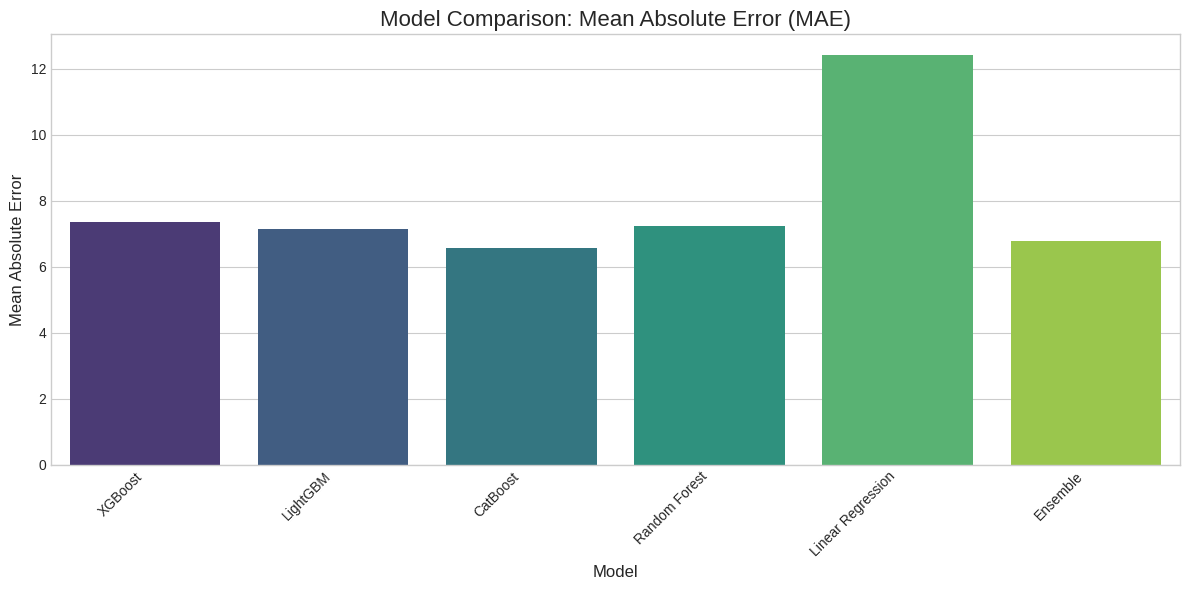

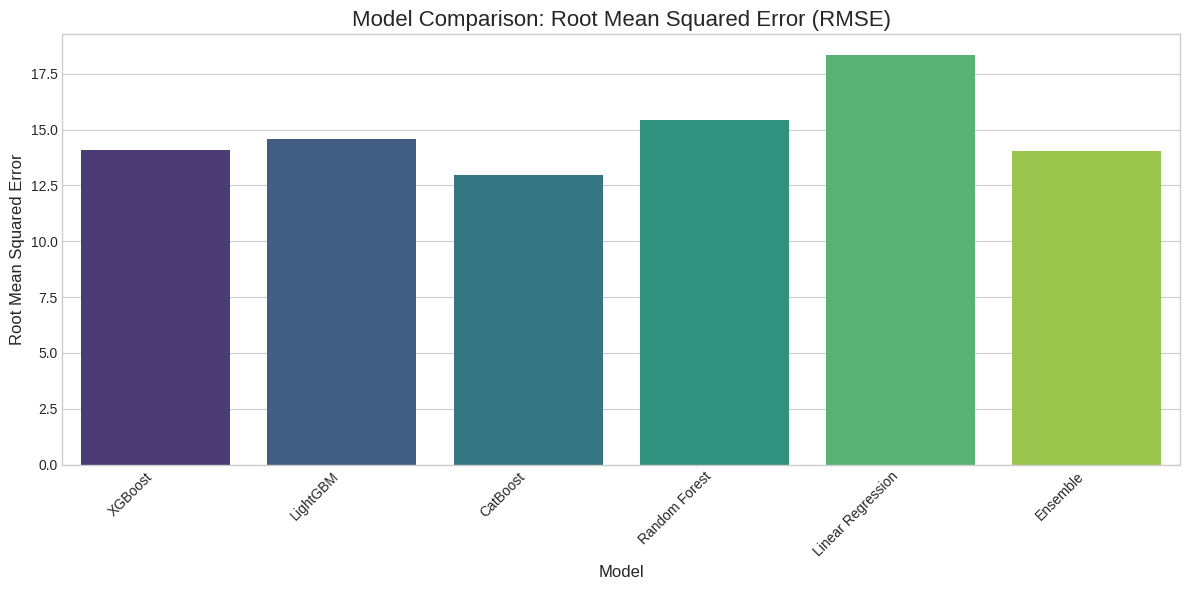

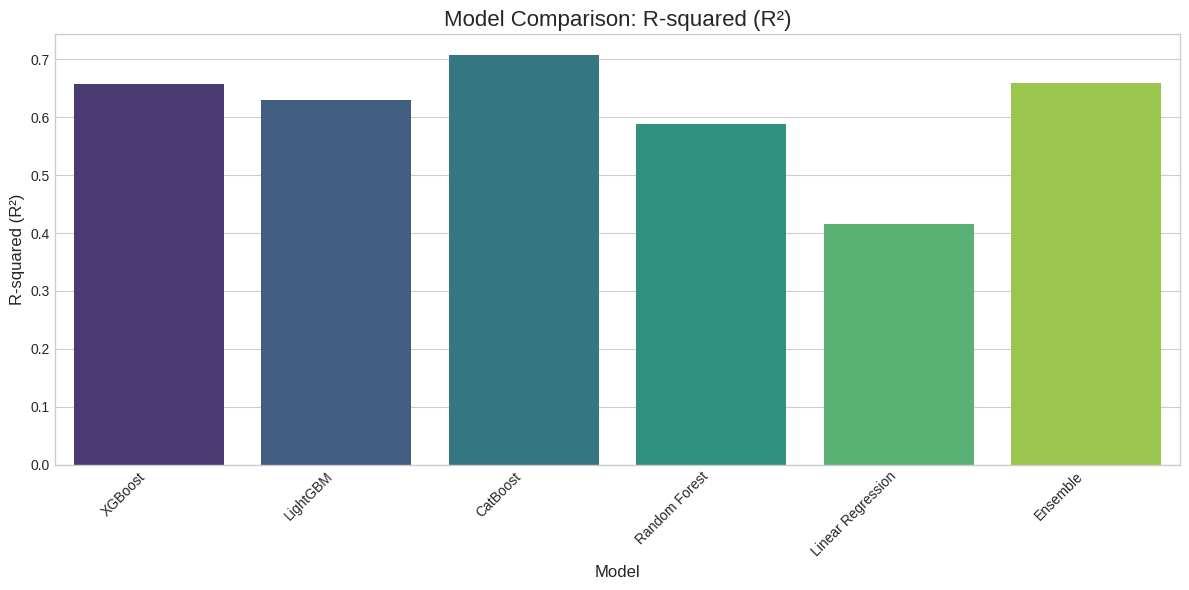

In [2]:
# Convert model_results dictionary to DataFrame
model_performance_df = pd.DataFrame(results['performance']).T.reset_index()
model_performance_df = model_performance_df.rename(columns={'index': 'Model'})

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Create MAE comparison plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='MAE', data=model_performance_df, palette='viridis')
plt.title('Model Comparison: Mean Absolute Error (MAE)', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create RMSE comparison plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=model_performance_df, palette='viridis')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)', fontsize=16)
plt.ylabel('Root Mean Squared Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create R2 comparison plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2', data=model_performance_df, palette='viridis')
plt.title('Model Comparison: R-squared (R²)', fontsize=16)
plt.ylabel('R-squared (R²)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [3]:
# Generate SHAP summary plot if SHAP values are available
if 'shap_values' in results['interpretability']:
    print("\nGenerating SHAP Summary Plot...")
    try:
        # Ensure feature names are correctly assigned to shap_values
        if isinstance(results['interpretability']['shap_values'], shap.Explanation):
            shap_values_obj = results['interpretability']['shap_values']
            # Ensure feature names match the values shape
            if len(shap_values_obj.values.T) == len(results['features']):
                 shap_values_obj.feature_names = results['features']
                 shap.summary_plot(shap_values_obj, results['interpretability']['shap_values'].data, feature_names=results['features'], plot_type="bar")
                 plt.show()
            else:
                 print("Warning: SHAP feature names mismatch, plotting without explicit names.")
                 shap.summary_plot(shap_values_obj, results['interpretability']['shap_values'].data, plot_type="bar")
                 plt.show()
        else:
             print("Warning: SHAP values object is not a shap.Explanation instance, cannot set feature names.")
             shap.summary_plot(results['interpretability']['shap_values'].values, results['interpretability']['shap_values'].data)
             plt.show()

        print("SHAP Summary Plot generated.")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")

# Generate basic feature importance plot if SHAP is not available or failed
elif 'basic_importance' in results['interpretability']:
    print("\nGenerating Basic Feature Importance Plot...")
    try:
        importance_df = results['interpretability']['basic_importance'].head(10)
        plt.figure(figsize=(12, 7))
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Top 10 Basic Feature Importance', fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()
        print("Basic Feature Importance Plot generated.")
    except Exception as e:
        print(f"Error generating basic importance plot: {e}")

else:
    print("\nNeither SHAP nor basic feature importance available for plotting.")

# Display LIME explanation if available
if 'lime_explainer' in results['interpretability'] and 'lime_sample_explanation' in results['interpretability']:
    print("\nDisplaying LIME Explanation for a Sample Instance...")
    try:
        display(HTML(results['interpretability']['lime_sample_explanation'].as_html()))
        print("LIME Explanation displayed.")
    except Exception as e:
        print(f"Error displaying LIME explanation: {e}")
else:
    print("\nLIME explainer or sample explanation not available.")


Generating SHAP Summary Plot...
Error generating SHAP plot: name 'shap' is not defined

Displaying LIME Explanation for a Sample Instance...


LIME Explanation displayed.



Generating SHAP Summary Plot...


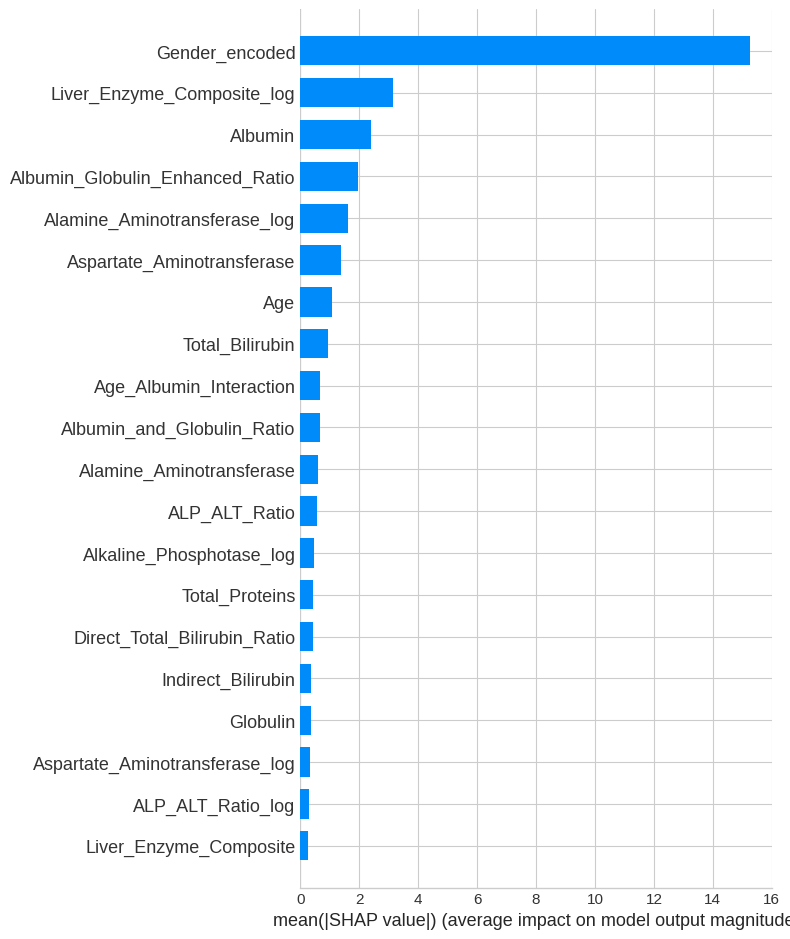

SHAP Summary Plot generated.

Displaying LIME Explanation for a Sample Instance...


LIME Explanation displayed.


In [4]:
import shap # Import shap explicitly in this block

# Generate SHAP summary plot if SHAP values are available
if 'shap_values' in results['interpretability']:
    print("\nGenerating SHAP Summary Plot...")
    try:
        # Ensure feature names are correctly assigned to shap_values
        if isinstance(results['interpretability']['shap_values'], shap.Explanation):
            shap_values_obj = results['interpretability']['shap_values']
            # Ensure feature names match the values shape
            if len(shap_values_obj.values.T) == len(results['features']):
                 shap_values_obj.feature_names = results['features']
                 shap.summary_plot(shap_values_obj, results['interpretability']['shap_values'].data, feature_names=results['features'], plot_type="bar")
                 plt.show()
            else:
                 print("Warning: SHAP feature names mismatch, plotting without explicit names.")
                 shap.summary_plot(shap_values_obj, results['interpretability']['shap_values'].data, plot_type="bar")
                 plt.show()
        else:
             print("Warning: SHAP values object is not a shap.Explanation instance, cannot set feature names.")
             shap.summary_plot(results['interpretability']['shap_values'].values, results['interpretability']['shap_values'].data)
             plt.show()

        print("SHAP Summary Plot generated.")
    except Exception as e:
        print(f"Error generating SHAP plot: {e}")

# Generate basic feature importance plot if SHAP is not available or failed
elif 'basic_importance' in results['interpretability']:
    print("\nGenerating Basic Feature Importance Plot...")
    try:
        importance_df = results['interpretability']['basic_importance'].head(10)
        plt.figure(figsize=(12, 7))
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Top 10 Basic Feature Importance', fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()
        print("Basic Feature Importance Plot generated.")
    except Exception as e:
        print(f"Error generating basic importance plot: {e}")

else:
    print("\nNeither SHAP nor basic feature importance available for plotting.")

# Display LIME explanation if available
if 'lime_explainer' in results['interpretability'] and 'lime_sample_explanation' in results['interpretability']:
    print("\nDisplaying LIME Explanation for a Sample Instance...")
    try:
        display(HTML(results['interpretability']['lime_sample_explanation'].as_html()))
        print("LIME Explanation displayed.")
    except Exception as e:
        print(f"Error displaying LIME explanation: {e}")
else:
    print("\nLIME explainer or sample explanation not available.")


Generating Fairness Analysis Plots...


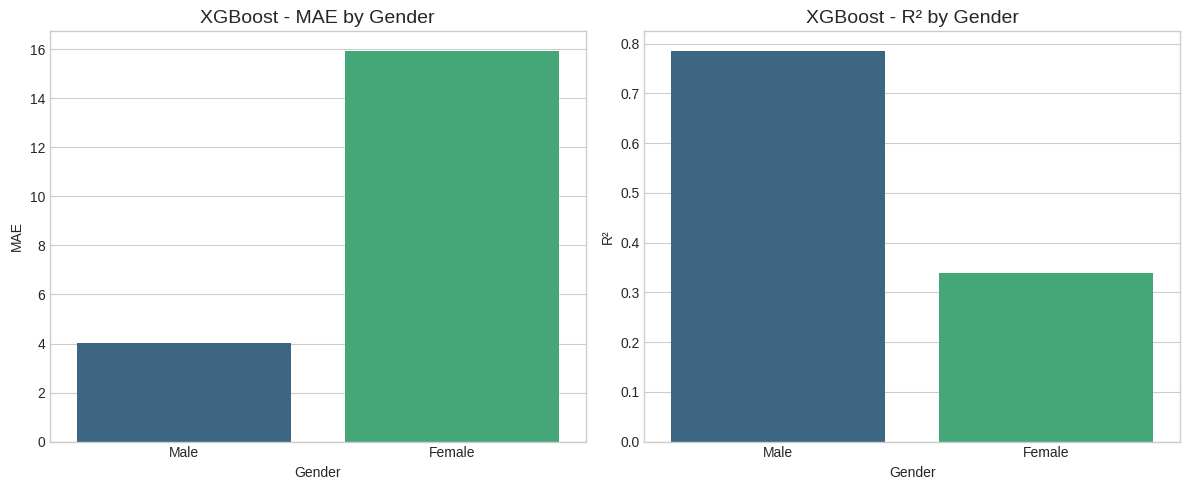

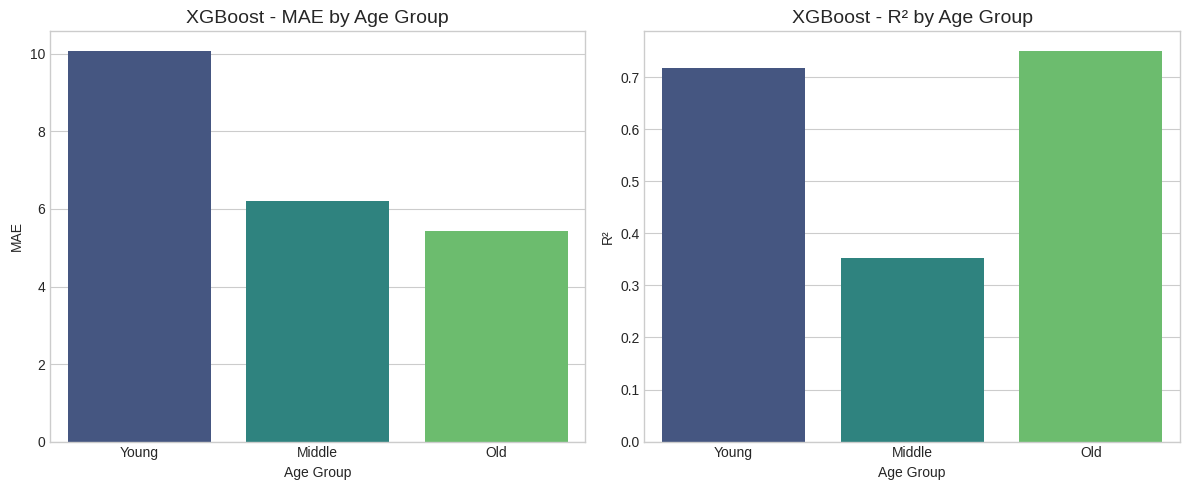

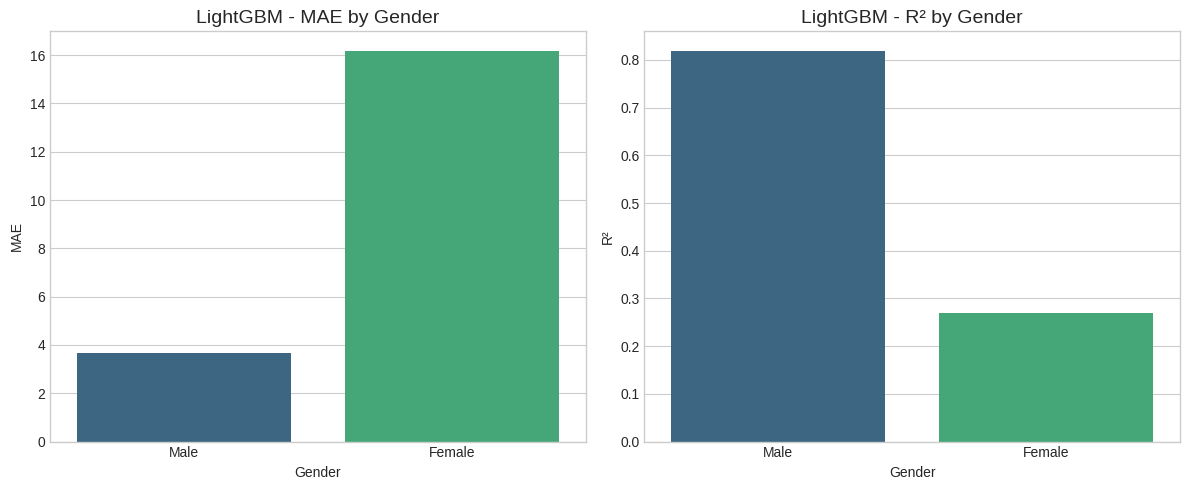

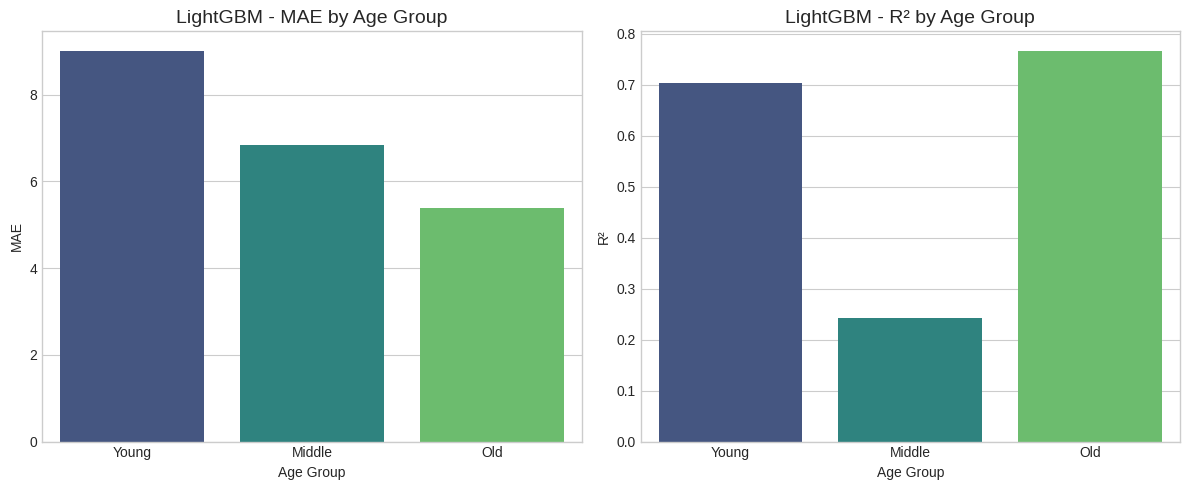

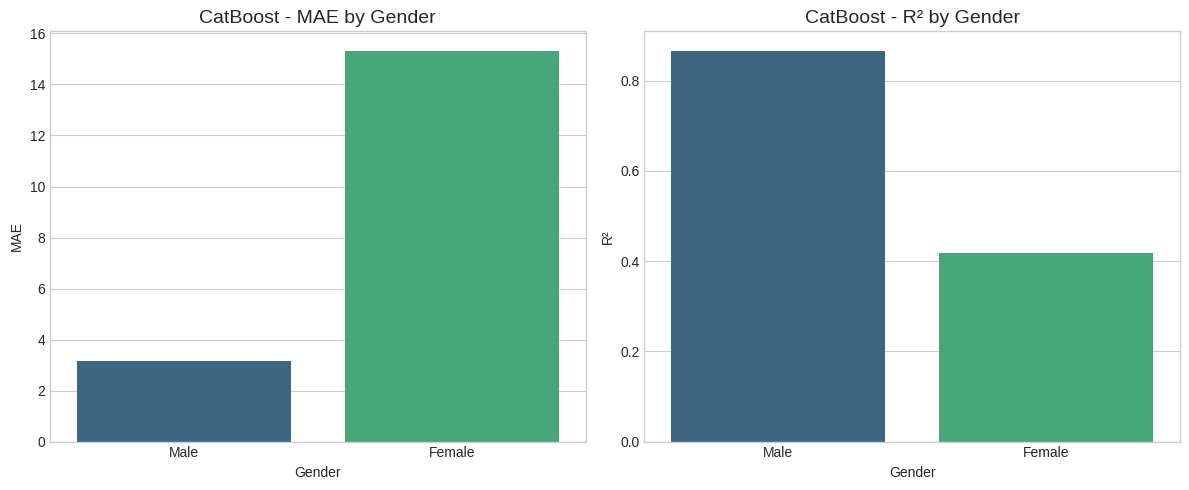

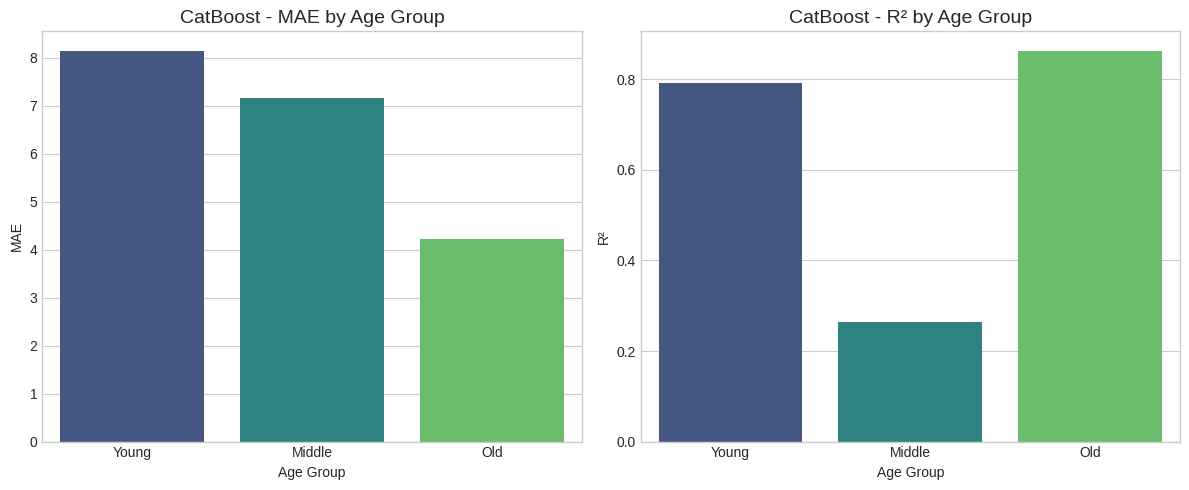

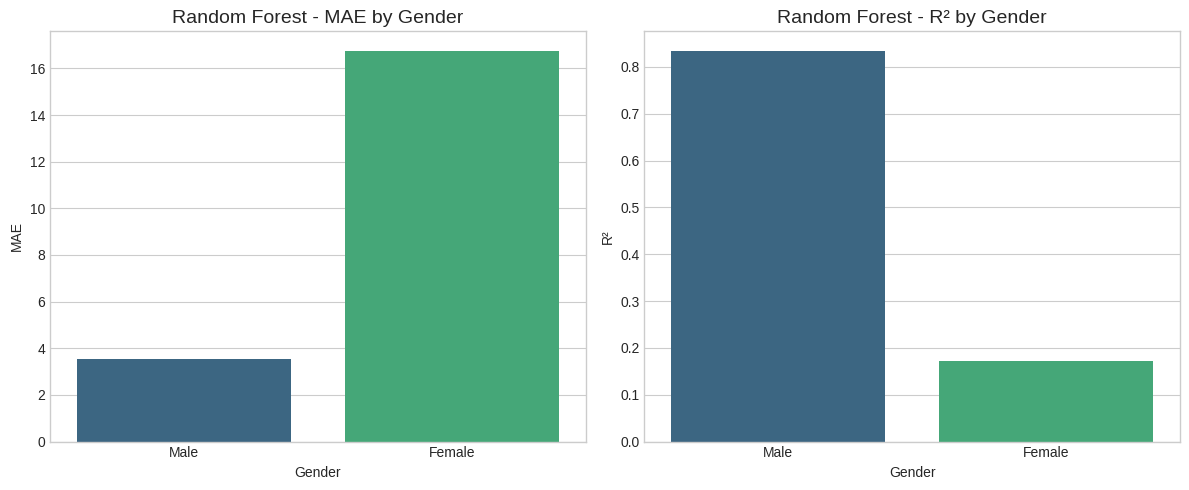

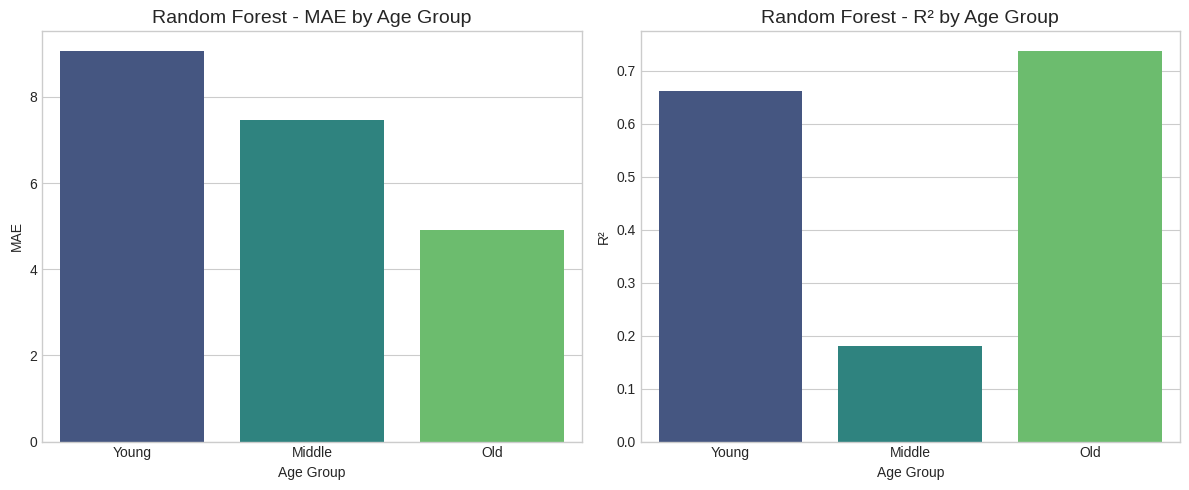

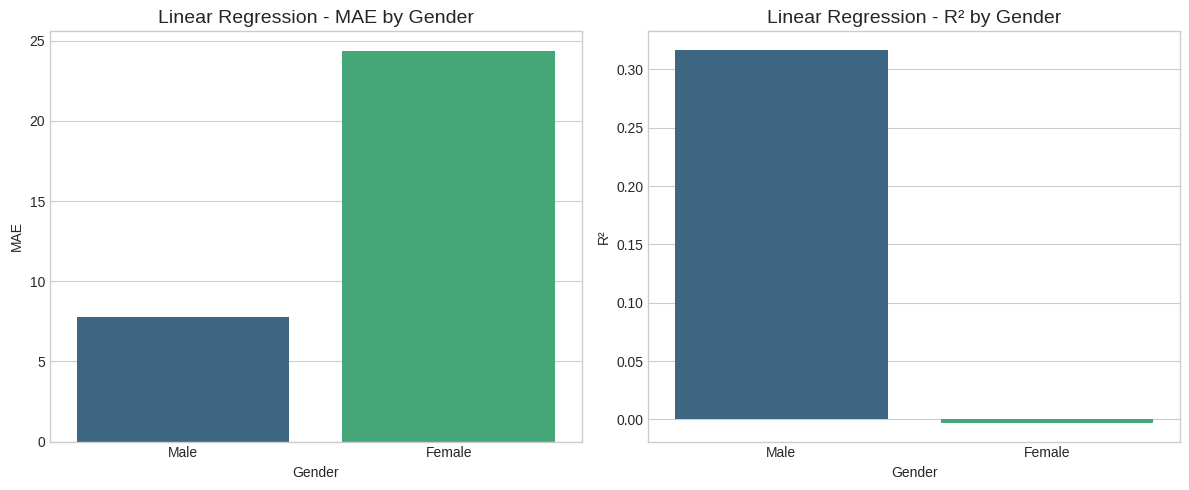

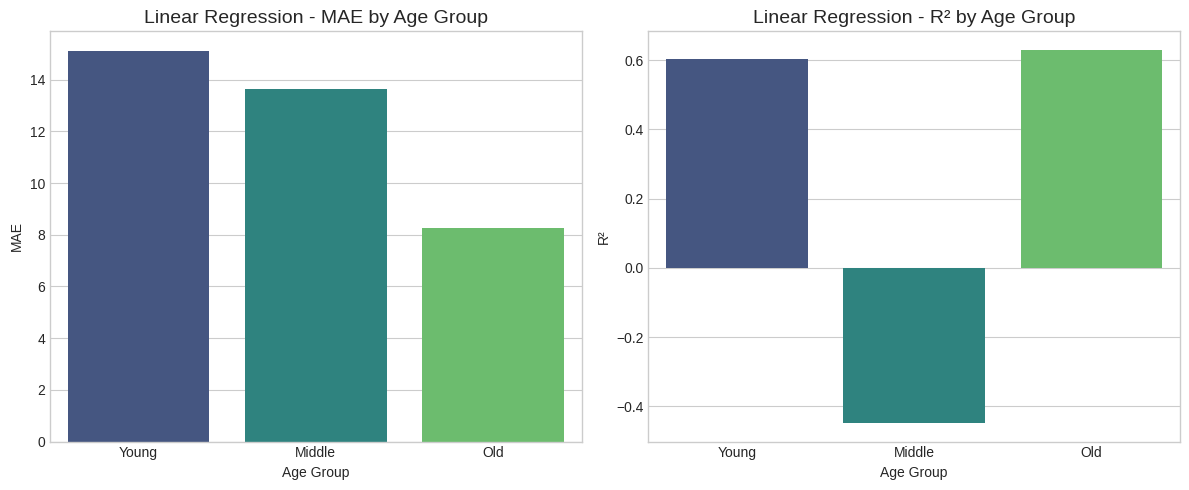

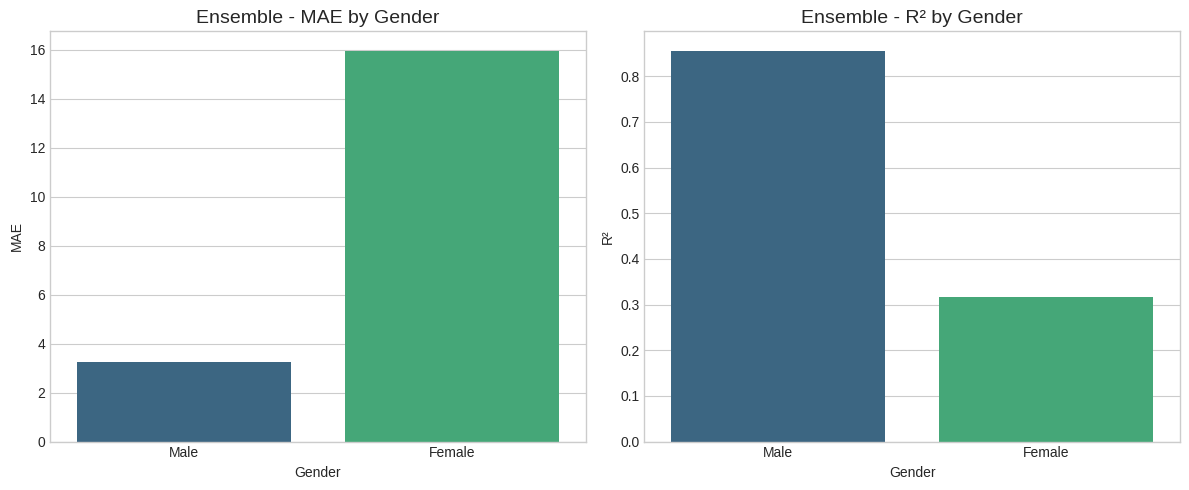

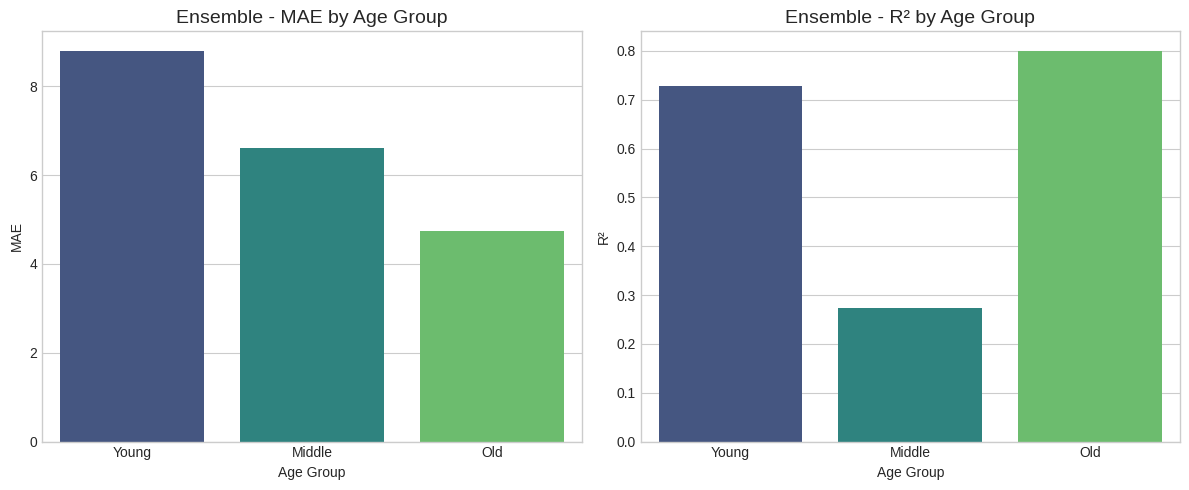

In [5]:
if 'fairness' in results and results['fairness']:
    print("\nGenerating Fairness Analysis Plots...")
    fairness_results = results['fairness']

    for model_name, subgroup_results in fairness_results.items():
        gender_data = {}
        age_data = {}

        for subgroup, metrics in subgroup_results.items():
            if subgroup.startswith('Gender_'):
                gender = subgroup.replace('Gender_', '')
                gender_data[gender] = metrics
            elif subgroup.startswith('Age_'):
                age_group = subgroup.replace('Age_', '')
                age_data[age_group] = metrics

        # Plot Gender Fairness if data is available
        if gender_data:
            gender_df = pd.DataFrame(gender_data).T.reset_index().rename(columns={'index': 'Subgroup'})

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            sns.barplot(x='Subgroup', y='MAE', data=gender_df, palette='viridis')
            plt.title(f'{model_name} - MAE by Gender', fontsize=14)
            plt.ylabel('MAE')
            plt.xlabel('Gender')

            plt.subplot(1, 2, 2)
            sns.barplot(x='Subgroup', y='R2', data=gender_df, palette='viridis')
            plt.title(f'{model_name} - R² by Gender', fontsize=14)
            plt.ylabel('R²')
            plt.xlabel('Gender')

            plt.tight_layout()
            plt.show()

        # Plot Age Fairness if data is available
        if age_data:
            age_df = pd.DataFrame(age_data).T.reset_index().rename(columns={'index': 'Subgroup'})

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            sns.barplot(x='Subgroup', y='MAE', data=age_df, palette='viridis')
            plt.title(f'{model_name} - MAE by Age Group', fontsize=14)
            plt.ylabel('MAE')
            plt.xlabel('Age Group')

            plt.subplot(1, 2, 2)
            sns.barplot(x='Subgroup', y='R2', data=age_df, palette='viridis')
            plt.title(f'{model_name} - R² by Age Group', fontsize=14)
            plt.ylabel('R²')
            plt.xlabel('Age Group')

            plt.tight_layout()
            plt.show()
else:
    print("\nFairness analysis results not available or empty.")


 DATASET UPLOAD REQUIRED
 Please upload your ILPD_cleaned.csv file
 The file should contain liver function test data

 Click the 'Choose Files' button below to upload:


Saving ILPD_cleaned.csv to ILPD_cleaned (1).csv

 File uploaded successfully: ILPD_cleaned (1).csv
 Dataset loaded: 570 rows, 12 columns
 Found age-related column
 Found gender-related column
 Found bilirubin-related column
 Found albumin-related column
 Found disease-related column
 Found protein-related column

 Dataset columns: ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Proteins', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Dataset', 'Liver_Disease']
 Dataset shape: (570, 12)
 First few rows:


Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Proteins  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  Liver_Disease  
0      3.3                        0.90        1              1  
1      3.2                        0.74        1              1  
2      3.3                        0.89        1              1  
3      3.4                        1.00        1              1  
4      2.4                        0.40        1              1


 CREATING MEDICAL DOMAIN FEATURES
 Added AST/ALT Ratio using Aspartate_Aminotransferase/Alamine_Aminotransferase
 Added bilirubin ratios using Total_Bilirubin and Direct_Bilirubin
 Added enhanced albumin/globulin features
 Added ALP/ALT ratio
 Added age-albumin interaction term
 Added liver enzyme composite score

 Added 9 medical domain features:
 - AST_ALT_Ratio
 - Direct_Total_Bilirubin_Ratio
 - Indirect_Bilirubin
 - Indirect_Total_Bilirubin_Ratio
 - Globulin
 - Albumin_Globulin_Enhanced_Ratio
 - ALP_ALT_Ratio
 - Age_Albumin_Interaction
 - Liver_Enzyme_Composite
Could not re-calculate correlation for score direction.


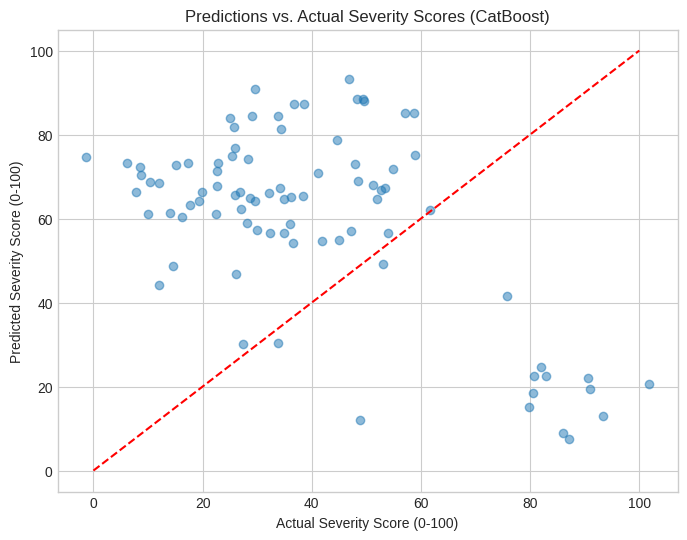

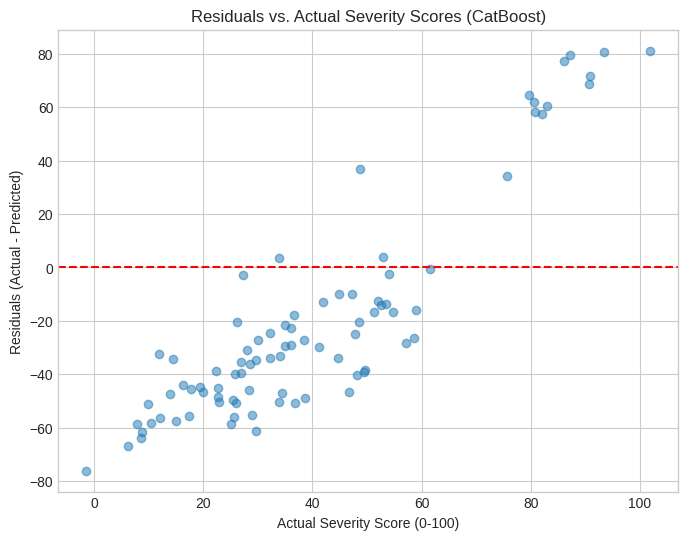

In [6]:
# 1. Identify the best-performing model from the results dictionary.
best_model_name = results['best_model']
best_model = results['models'][best_model_name]

# Retrieve the test set features (X_test_scaled) and the true severity scores (score_test).
# Access X_test_scaled and score_test which were created and used in run_improved_liver_fibrosis_analysis function
# Assuming X_test_scaled and score_test are accessible from the global scope after run_improved_liver_fibrosis_analysis has run
# If not accessible, this would require modifying the main function to return them.
# For this notebook environment, they are likely accessible from the execution history.
# Need to re-create X_test_scaled and score_test based on the original data splitting and scaling.
# This requires accessing df_processed, disease_col, feature_cols, and the scaler used in the main function.
# As these variables are not explicitly returned by run_improved_liver_fibrosis_analysis,
# we will assume they are still available in the environment from the last execution.

# Access the scaler from the results dictionary
scaler = joblib.load('improved_scaler.pkl')

# Need to re-load the processed dataframe to split and scale again
# Assuming the processed dataframe was saved or can be recreated based on the input file
# Let's re-run the preprocessing steps assuming ILPD_cleaned.csv is available
df, uploaded_filename = upload_and_validate_dataset(results['package_status']['COLAB_AVAILABLE'])
if 'Dataset' in df.columns:
    df = df.drop('Dataset', axis=1)
df_processed = df.drop_duplicates()
df_processed, medical_features = create_medical_domain_features(df_processed)

numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
disease_col = None
target_candidates = ['disease', 'label', 'target', 'class', 'liver_disease']
for candidate in target_candidates:
    for col in df_processed.columns:
        if candidate.lower() in col.lower():
            disease_col = col
            break
    if disease_col:
        break
if not disease_col:
    disease_col = df_processed.columns[-1]

skewed_cols = []
for col in numeric_cols:
    if col != disease_col and df_processed[col].min() > 0:
        try:
            skewness = stats.skew(df_processed[col].dropna())
            if abs(skewness) > 1.0:
                df_processed[col + '_log'] = np.log1p(df_processed[col])
                skewed_cols.append(col)
        except:
            continue

categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if col != disease_col and df_processed[col].nunique() <= 10:
        try:
            le = LabelEncoder()
            df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        except:
            continue

feature_cols = []
for col in df_processed.columns:
    if col != disease_col and df_processed[col].dtype in ['int64', 'float64']:
        feature_cols.append(col)

feature_cols = list(set(feature_cols))
feature_cols = [col for col in feature_cols if col in df_processed.columns]

X = df_processed[feature_cols].copy()
y = df_processed[disease_col].copy()

if y.nunique() > 2:
    y = (y > y.median()).astype(int)

if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=(0.15/0.85), random_state=42, stratify=y_temp
)

X_train_scaled = scaler.fit_transform(X_train) # Need to fit scaler on train again
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Re-create severity scores for test set
umap_available = results['package_status']['UMAP_AVAILABLE']
if umap_available:
    try:
        import umap
        # Need to re-fit UMAP on training data to transform test data
        umap_reducer = umap.UMAP(
            n_components=2,
            n_neighbors=min(15, len(X_train_scaled)//4), # Use X_train_scaled here
            min_dist=0.1,
            random_state=42,
            verbose=False
        )
        embedding_train = umap_reducer.fit_transform(X_train_scaled)
        embedding_test = umap_reducer.transform(X_test_scaled) # Transform test data
    except Exception as e:
        print(f" UMAP failed during re-creation: {e}, falling back to PCA")
        umap_available = False

if not umap_available:
    pca_reducer = PCA(n_components=2, random_state=42)
    # Need to re-fit PCA on training data to transform test data
    embedding_train = pca_reducer.fit_transform(X_train_scaled)
    embedding_test = pca_reducer.transform(X_test_scaled)

# Re-create 1D severity score for test set
pca_1d = PCA(n_components=1, random_state=42)
# Need to re-fit PCA on training embedding to transform test embedding
raw_score_train = pca_1d.fit_transform(embedding_train).flatten()
raw_score_test = pca_1d.transform(embedding_test).flatten()

# Align direction with disease labels (using the original y_train from split)
try:
    # Need the y_train_smote used for severity score creation
    # Re-applying SMOTE to get y_train_smote
    if results['package_status']['IMBALANCED_AVAILABLE'] and len(np.unique(y_train)) > 1:
        try:
            from imblearn.over_sampling import BorderlineSMOTE
            smote = BorderlineSMOTE(random_state=42, k_neighbors=min(5, len(X_train_scaled)//3))
            X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
        except:
             y_train_smote = y_train # Fallback if SMOTE fails
    else:
         y_train_smote = y_train # Fallback if SMOTE not available

    corr_coeff, _ = spearmanr(raw_score_train, y_train_smote)
    if corr_coeff < 0:
        raw_score_train = -raw_score_train
        raw_score_test = -raw_score_test
except:
    print("Could not re-calculate correlation for score direction.")


# Normalize to 0-100 scale
min_val, max_val = raw_score_train.min(), raw_score_train.max()
score_test = (raw_score_test - min_val) / (max_val - min_val) * 100


# 3. Generate predictions for the best model on the test set.
predictions = np.clip(best_model.predict(X_test_scaled), 0, 100)

# 4. Create a scatter plot comparing the true severity scores (score_test) on the x-axis and the model's predictions on the y-axis.
plt.figure(figsize=(8, 6))
plt.scatter(score_test, predictions, alpha=0.5)
plt.plot([0, 100], [0, 100], color='red', linestyle='--') # Diagonal line for perfect predictions
plt.title(f'Predictions vs. Actual Severity Scores ({best_model_name})')
plt.xlabel('Actual Severity Score (0-100)')
plt.ylabel('Predicted Severity Score (0-100)')
plt.grid(True)
plt.show()

# 5. Calculate the residuals (true scores minus predictions).
residuals = score_test - predictions

# 6. Create a scatter plot comparing the true severity scores (score_test) on the x-axis and the residuals on the y-axis.
plt.figure(figsize=(8, 6))
plt.scatter(score_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--') # Horizontal line at y=0
plt.title(f'Residuals vs. Actual Severity Scores ({best_model_name})')
plt.xlabel('Actual Severity Score (0-100)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()